#Mount Google Drive and Install Dependencies

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

!python -m pip install pyyaml==5.1
import sys, os, distutils.core

!git clone 'https://github.com/facebookresearch/detectron2'
dist = distutils.core.run_setup("./detectron2/setup.py")
!python -m pip install {' '.join([f"'{x}'" for x in dist.install_requires])}
sys.path.insert(0, os.path.abspath('./detectron2'))


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
  Using cached PyYAML-5.1.tar.gz (274 kB)
  error: subprocess-exited-with-error
  
  × python setup.py egg_info did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  Preparing metadata (setup.py) ... error
error: metadata-generation-failed

× Encountered error while generating package metadata.
╰─> See above for output.

note: This is an issue with the package mentioned above, not pip.
hint: See above for details.
fatal: destination path 'detectron2' already exists and is not an empty directory.


#Setuo Dectron2 and Import Libraries

In [ ]:
# Setup detectron2 logger
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()

# import some common libraries
import numpy as np
import os, json, cv2, random
import matplotlib.pyplot as plt
from google.colab.patches import cv2_imshow

# import some common detectron2 utilities
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor, DefaultTrainer
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer, ColorMode
from detectron2.data import MetadataCatalog, DatasetCatalog
from detectron2.data.datasets import register_coco_instances
from detectron2.structures import BoxMode
from detectron2.evaluation import COCOEvaluator, inference_on_dataset
from detectron2.data import build_detection_test_loader


#Convert JSON files and Merge Data

In [ ]:
def convert_json_files(json_dir, image_dir, images, annotations, start_image_id, start_annotation_id):
    current_image_id = start_image_id
    current_annotation_id = start_annotation_id

    for json_file in os.listdir(json_dir):
        if json_file.endswith(".json"):
            json_path = os.path.join(json_dir, json_file)
            with open(json_path) as f:
                data = json.load(f)

            for entry in data["FILE"]:
                file_name = entry["FILE_NAME"]
                file_path = os.path.join(image_dir, file_name)
                if not os.path.exists(file_path):
                    continue

                # Read image size
                height, width = cv2.imread(file_path).shape[:2]

                # Append image info
                images.append({
                    "file_name": file_path,
                    "height": height,
                    "width": width,
                    "id": current_image_id
                })

                for item in entry["ITEMS"]:
                    if item["DRAWING"] == "Box":
                        bbox = list(map(float, item["BOX"].split(',')))
                        xmin, ymin, width, height = bbox[0], bbox[1], bbox[2], bbox[3]

                        # Determine class based on "CLASS" field
                        class_name = item["CLASS"]
                        if class_name == "적재불량":
                            category_id = 1
                        elif class_name == "정상차량":
                            category_id = 0
                        else:
                            continue  # Ignore entries that are not classified as "적재불량" or "정상차량"

                        # Append annotation info
                        annotations.append({
                            "bbox": [xmin, ymin, width, height],
                            "bbox_mode": BoxMode.XYWH_ABS,
                            "category_id": category_id,
                            "image_id": current_image_id,
                            "id": current_annotation_id,
                            "segmentation": [],
                            "area": width * height,
                            "iscrowd": 0
                        })
                        current_annotation_id += 1

                current_image_id += 1

    return current_image_id, current_annotation_id

def merge_json_files(training=True):
    base_dir = "/content/drive/MyDrive/Data/training" if training else "/content/drive/MyDrive/Data/validation" # 데이터 경로 지정 필요

    merged_data = {
        "images": [],
        "annotations": [],
        "categories": [
            {"id": 0, "name": "normal_vehicle"},  # 정상 차량
            {"id": 1, "name": "overloaded_vehicle"}  # 적재불량 차량
        ]
    }

    current_image_id = 0
    current_annotation_id = 0

    json_dir = os.path.join(base_dir, "labeled")
    image_dir = os.path.join(base_dir, "source")

    current_image_id, current_annotation_id = convert_json_files(
        json_dir, image_dir,
        merged_data["images"], merged_data["annotations"],
        current_image_id, current_annotation_id
    )

    output_file = "merged_training_annotations.json" if training else "merged_validation_annotations.json"
    with open(output_file, 'w') as f:
        json.dump(merged_data, f, indent=4)

# Training 데이터셋 병합 및 변환
merge_json_files(training=True)

# Validation 데이터셋 병합 및 변환
merge_json_files(training=False)


#Register Datates and Visualize

Train Dataset Metadata: Metadata(name='vehicle_train', json_file='merged_training_annotations.json', image_root='/content/drive/MyDrive/Data', evaluator_type='coco')
Validation Dataset Metadata: Metadata(name='vehicle_val', json_file='merged_validation_annotations.json', image_root='/content/drive/MyDrive/Data', evaluator_type='coco')
WARNING [06/18 06:28:51 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

[06/18 06:28:51 d2.data.datasets.coco]: Loaded 280 images in COCO format from merged_training_annotations.json


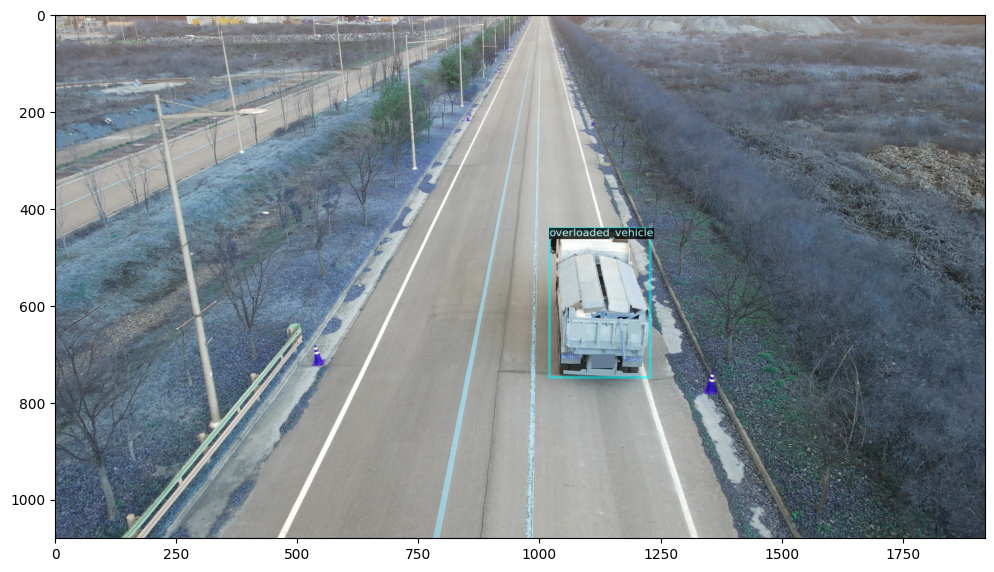

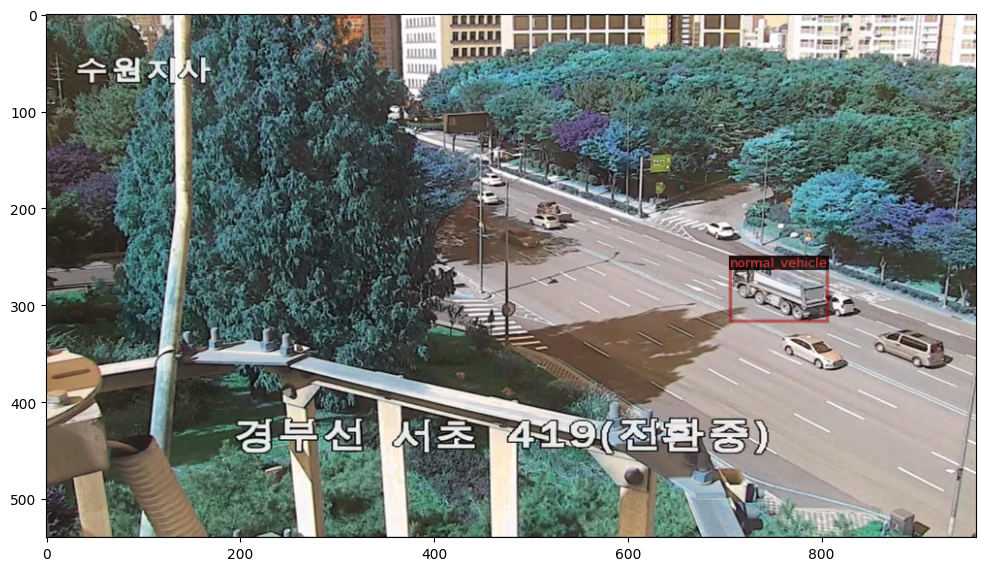

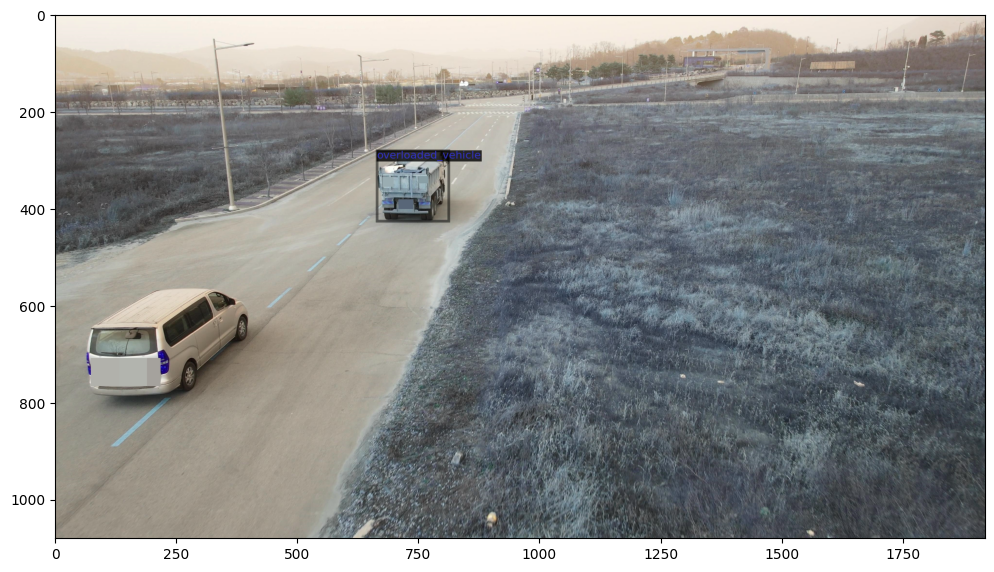

In [ ]:
# 파일 경로 설정
training_json = "merged_training_annotations.json"
validation_json = "merged_validation_annotations.json"
image_dir = "/content/drive/MyDrive/Data"  # 경로 지정 필요

# 데이터셋 등록
register_coco_instances("vehicle_train", {}, training_json, image_dir)
register_coco_instances("vehicle_val", {}, validation_json, image_dir)

# 메타데이터 가져오기
train_metadata = MetadataCatalog.get("vehicle_train")
val_metadata = MetadataCatalog.get("vehicle_val")

print("Train Dataset Metadata:", train_metadata)
print("Validation Dataset Metadata:", val_metadata)

# training 데이터셋 시각화
train_dataset_dicts = DatasetCatalog.get("vehicle_train")
for d in random.sample(train_dataset_dicts, 3):
    img = cv2.imread(d["file_name"])
    visualizer = Visualizer(img[:, :, ::-1], metadata=train_metadata, scale=0.5)
    out = visualizer.draw_dataset_dict(d)
    plt.figure(figsize=(12, 8))
    plt.imshow(out.get_image()[:, :, ::-1])
    plt.show()


#Train the model

In [ ]:
cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-Detection/faster_rcnn_R_50_FPN_3x.yaml"))
cfg.DATASETS.TRAIN = ("vehicle_train",)
cfg.DATASETS.TEST = ("vehicle_val",)
cfg.DATALOADER.NUM_WORKERS = 2
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-Detection/faster_rcnn_R_50_FPN_3x.yaml")  # 사전 학습된 모델 사용
cfg.SOLVER.IMS_PER_BATCH = 2
cfg.SOLVER.BASE_LR = 0.00025
cfg.SOLVER.MAX_ITER = 1000  # 학습 반복 횟수 조정
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 128
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 2  # 두 가지 클래스: 정상차량과 적재불량 차량

os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)
trainer = DefaultTrainer(cfg)
trainer.resume_or_load(resume=False)
trainer.train()


[06/18 06:28:56 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res

roi_heads.box_predictor.bbox_pred.{bias, weight}
roi_heads.box_predictor.cls_score.{bias, weight}


[06/18 06:28:57 d2.engine.train_loop]: Starting training from iteration 0


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/local/lib/python3.10/dist-packages/torch/functional.py:512: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3587.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


[06/18 06:29:12 d2.utils.events]:  eta: 0:09:11  iter: 19  total_loss: 1.508  loss_cls: 1.103  loss_box_reg: 0.3853  loss_rpn_cls: 0.01687  loss_rpn_loc: 0.001832    time: 0.5910  last_time: 0.5240  data_time: 0.1534  last_data_time: 0.0059   lr: 4.9953e-06  max_mem: 2546M
[06/18 06:29:28 d2.utils.events]:  eta: 0:09:10  iter: 39  total_loss: 1.45  loss_cls: 0.9994  loss_box_reg: 0.41  loss_rpn_cls: 0.02189  loss_rpn_loc: 0.001673    time: 0.5966  last_time: 0.6591  data_time: 0.0941  last_data_time: 0.1764   lr: 9.9902e-06  max_mem: 2547M
[06/18 06:29:39 d2.utils.events]:  eta: 0:08:49  iter: 59  total_loss: 1.316  loss_cls: 0.8376  loss_box_reg: 0.4319  loss_rpn_cls: 0.02303  loss_rpn_loc: 0.001723    time: 0.5880  last_time: 0.5445  data_time: 0.0853  last_data_time: 0.0096   lr: 1.4985e-05  max_mem: 2547M
[06/18 06:29:53 d2.utils.events]:  eta: 0:08:41  iter: 79  total_loss: 1.08  loss_cls: 0.6489  loss_box_reg: 0.374  loss_rpn_cls: 0.01588  loss_rpn_loc: 0.001929    time: 0.6117  

#Evaluate Model Performance

In [ ]:
cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-Detection/faster_rcnn_R_50_FPN_3x.yaml"))
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 2  # "적재불량 차량"과 "정상 차량" 두 가지 클래스
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")  # 학습된 모델 가중치
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.7  # 테스트 시 사용할 confidence threshold

predictor = DefaultPredictor(cfg)

# 이미지에 대해 추론 수행
def perform_inference(image_path, predictor, metadata):
    if not os.path.isfile(image_path):
        print(f"Error: File {image_path} does not exist.")
        return

    img = cv2.imread(image_path)
    if img is None:
        print(f"Error: Failed to load image {image_path}.")
        return

    outputs = predictor(img)

    v = Visualizer(img[:, :, ::-1], metadata=metadata, scale=0.5, instance_mode=ColorMode.IMAGE_BW)
    out = v.draw_instance_predictions(outputs["instances"].to("cpu"))

    plt.figure(figsize=(14, 10))
    plt.imshow(out.get_image()[:, :, ::-1])
    plt.axis('off')
    plt.show()

# 테스트 이미지 경로 설정
test_image_path = "/content/drive/MyDrive/Data/validation/source"  # 경로 지정 필요
perform_inference(test_image_path, predictor, MetadataCatalog.get("vehicle_train"))

# 평가를 위한 데이터 로더 및 평가자 초기화
evaluator = COCOEvaluator("vehicle_val", output_dir="./output")
val_loader = build_detection_test_loader(cfg, "vehicle_val")

# 모델 성능 평가.
evaluation_results = inference_on_dataset(predictor.model, val_loader, evaluator)
print(evaluation_results)


[06/18 06:39:46 d2.checkpoint.detection_checkpoint]: [DetectionCheckpointer] Loading from ./output/model_final.pth ...
Error: File /content/drive/MyDrive/Data/validation/source does not exist.
[06/18 06:39:47 d2.evaluation.coco_evaluation]: Fast COCO eval is not built. Falling back to official COCO eval.
WARNING [06/18 06:39:47 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

[06/18 06:39:47 d2.data.datasets.coco]: Loaded 60 images in COCO format from merged_validation_annotations.json
[06/18 06:39:47 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in inference: [ResizeShortestEdge(short_edge_length=(800, 800), max_size=1333, sample_style='choice')]
[06/18 06:39:47 d2.data.common]: Serializing the dataset using: <class 'detectron2.data.common._TorchSerializedList'>
[06/18 06:39:47 d2.data.common]: Serializing 60 elements to byte tensors and concatenating them all ...
[06/18 06:39:47 d2.data.common]: Serialized

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


[06/18 06:39:53 d2.evaluation.evaluator]: Inference done 11/60. Dataloading: 0.1630 s/iter. Inference: 0.1923 s/iter. Eval: 0.0044 s/iter. Total: 0.3597 s/iter. ETA=0:00:17
[06/18 06:39:58 d2.evaluation.evaluator]: Inference done 23/60. Dataloading: 0.2123 s/iter. Inference: 0.1886 s/iter. Eval: 0.0025 s/iter. Total: 0.4040 s/iter. ETA=0:00:14
[06/18 06:40:03 d2.evaluation.evaluator]: Inference done 58/60. Dataloading: 0.0873 s/iter. Inference: 0.1433 s/iter. Eval: 0.0011 s/iter. Total: 0.2321 s/iter. ETA=0:00:00
[06/18 06:40:03 d2.evaluation.evaluator]: Total inference time: 0:00:12.661144 (0.230203 s / iter per device, on 1 devices)
[06/18 06:40:03 d2.evaluation.evaluator]: Total inference pure compute time: 0:00:07 (0.142352 s / iter per device, on 1 devices)
[06/18 06:40:03 d2.evaluation.coco_evaluation]: Preparing results for COCO format ...
[06/18 06:40:03 d2.evaluation.coco_evaluation]: Saving results to ./output/coco_instances_results.json
[06/18 06:40:03 d2.evaluation.coco_eva

# easy ocr


#result image saving

In [ ]:
from detectron2.utils.visualizer import Visualizer, ColorMode
from detectron2.data import MetadataCatalog, build_detection_test_loader
from detectron2.evaluation import COCOEvaluator, inference_on_dataset

cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-Detection/faster_rcnn_R_50_FPN_3x.yaml"))
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 2
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.7

predictor = DefaultPredictor(cfg)

# 이미지에 대해 추론을 수행하고 결과를 저장하는 함수
def perform_inference(image_path, predictor, metadata):
    result_overload = []
    if not os.path.isfile(image_path):
        print(f"Error: File {image_path} does not exist.")
        return result_overload

    img = cv2.imread(image_path)
    if img is None:
        print(f"Error: Failed to load image {image_path}.")
        return result_overload

    outputs = predictor(img)

    v = Visualizer(img[:, :, ::-1], metadata=metadata, scale=0.5, instance_mode=ColorMode.IMAGE_BW)
    out = v.draw_instance_predictions(outputs["instances"].to("cpu"))
    result_overload.append(out.get_image()[:, :, ::-1])

    return result_overload

# 테스트 이미지 경로 설정
test_image_path = "/content/drive/MyDrive/Data/validation/source"  # 경로 지정 필요

# 결과 저장
result_overload = perform_inference(test_image_path, predictor, MetadataCatalog.get("vehicle_train"))

# 결과 시각화
for result in result_overload:
    plt.figure(figsize=(14, 10))
    plt.imshow(result)
    plt.axis('off')
    plt.show()


[06/18 06:40:04 d2.checkpoint.detection_checkpoint]: [DetectionCheckpointer] Loading from ./output/model_final.pth ...
Error: File /content/drive/MyDrive/Data/validation/source does not exist.


#import easy ocr

In [ ]:
#you need to install pytorch in anaconda environment
import os
import locale
import subprocess

# Check if locale is set correctly locale.setlocale(locale.LC_ALL, 'UTF-8')
import locale
locale.getpreferredencoding = lambda: "UTF-8"

!pip install transformers==4.28.1

# Install EasyOCR
!pip install easyocr

import torch.backends.cudnn as cudnn
import yaml
import pandas as pd
import easyocr

# Uncomment if these are defined elsewhere
# from train import train
# from utils import AttrDict

cudnn.benchmark = True
cudnn.deterministic = False

reader = easyocr.Reader(['ko']) # this needs to run only once to load the model into memory

#파일 불러오기

In [ ]:
import os
import cv2 as cv

# Iterate over the files in the directory
for i in os.listdir(result_overload):
    path = result_overload + i

    # Read the image
    img_color = cv.imread(path, cv.IMREAD_COLOR)

    # Display the image
    cv.imshow("image", img_color)
    cv.waitKey(0)

# Read the Chinese image
img = cv2.imread(result_overload)

# Perform OCR on the image
result = reader.readtext(img, detail=0)

TypeError: listdir: path should be string, bytes, os.PathLike, integer or None, not list